# Polka et al Analysis Reviewer Request

A reviewer requested that the regression analysis for document distances be filtered to only include documents that were published within the same time frame as preprints mentioned in polka et al subset. Rather than edit the old notebook I'm generating a new notebook to only include that updated part of the analysis.

In [1]:
from datetime import timedelta, date
from pathlib import Path
import sys

from cairosvg import svg2png
from gensim.models import Word2Vec
from IPython.display import Image, display, SVG
from lxml import etree
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import plotnine as p9
from scipy.spatial.distance import cdist
from scipy.stats import linregress
import seaborn as sns
from svgutils.compose import Unit
import svgutils.transform as sg
import tqdm

from annorxiver_modules.document_helper import generate_doc_vector

mpl.rcParams["figure.dpi"] = 250

# Load the document vectors

In [2]:
biorxiv_documents_df = pd.read_csv(
    "../word_vector_experiment/output/word2vec_output/biorxiv_all_articles_300.tsv.xz",
    sep="\t",
)
biorxiv_documents_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,440735_v1.xml,0.063813,0.012187,-0.156229,-0.158987,0.165480,-0.346612,0.001741,-0.107139,0.684055,...,-0.140772,-0.143405,-0.081427,-0.248220,-0.771470,-0.235455,0.547801,0.859663,-0.063151,0.012667
1,775270_v1.xml,-0.201064,0.011870,-0.354809,-0.150633,0.095305,-0.507254,-0.339986,0.303313,0.944561,...,-0.115199,-0.259798,0.272955,-0.346138,-0.844158,-0.596267,0.121678,0.959160,-0.747369,-0.073314
2,242404_v1.xml,-0.204741,-0.107589,-0.062853,0.140793,0.066307,-0.463290,-0.106492,-0.040269,0.557687,...,-0.229839,-0.325765,-0.064586,-0.300529,-0.707948,-0.479390,0.381809,0.968333,-0.402499,-0.109250
3,872994_v1.xml,-0.256990,-0.055972,-0.300816,0.495731,0.290070,-0.310817,-0.481578,-0.161373,0.483896,...,0.148916,-0.217426,0.195183,-0.069086,-0.545689,-0.517949,0.265230,0.645038,-0.843499,-0.142928
4,080853_v2.xml,0.167641,0.046808,-0.709753,0.232242,-0.139213,-0.319284,-0.314807,0.310180,0.317704,...,0.540693,0.264286,0.256323,0.137184,-0.754344,-0.145583,0.032544,0.507430,-0.374320,0.473060


In [3]:
polka_preprints_df = pd.read_csv("output/polka_et_al_biorxiv_embeddings.tsv", sep="\t")
polka_preprints_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,838870_v1.xml,-0.236496,-0.158390,-0.137343,-0.001011,-0.284048,-0.271869,0.041991,0.120466,0.264844,...,0.125062,-0.135080,0.170882,-0.308521,-0.600287,-0.345592,0.039640,0.730110,-0.348575,0.372932
1,2020.02.13.945485_v1.xml,-0.209540,0.062120,-0.013421,-0.000279,-0.314423,-0.326985,0.110545,0.243373,0.338386,...,-0.119528,0.035750,-0.064431,-0.094898,-0.711048,-0.044813,0.324615,0.655335,-0.402705,0.460434
2,2020.01.13.905190_v1.xml,0.229247,0.103720,-0.675217,-0.279651,0.141527,-0.414926,-0.125090,0.169768,0.501925,...,0.282492,0.042949,0.182784,-0.178214,-0.292325,0.067889,0.266495,0.434768,-0.672433,0.628961
3,865089_v1.xml,0.259484,0.187865,-0.476495,0.104272,-0.239906,-0.327997,0.087983,0.278655,0.548521,...,0.273547,0.442512,0.137913,-0.376542,-0.662379,-0.009104,0.152630,0.026150,-0.478900,0.473070
4,832675_v1.xml,0.331504,0.397300,-0.662221,-0.082239,0.142704,-0.483719,-0.225434,0.289693,0.750071,...,0.357520,0.031200,0.369862,-0.425790,-0.461598,-0.768766,0.229174,0.504789,-0.708815,0.094324


In [4]:
polka_preprints_df = polka_preprints_df.assign(
    biorxiv_base=lambda x: x.document.apply(lambda y: y.split("_")[0]),
    version_count=lambda x: x.document.apply(
        lambda y: int(y[y.index("v") + 1 :].split(".")[0])
    ),
)
polka_preprints_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299,biorxiv_base,version_count
0,838870_v1.xml,-0.236496,-0.158390,-0.137343,-0.001011,-0.284048,-0.271869,0.041991,0.120466,0.264844,...,0.170882,-0.308521,-0.600287,-0.345592,0.039640,0.730110,-0.348575,0.372932,838870,1
1,2020.02.13.945485_v1.xml,-0.209540,0.062120,-0.013421,-0.000279,-0.314423,-0.326985,0.110545,0.243373,0.338386,...,-0.064431,-0.094898,-0.711048,-0.044813,0.324615,0.655335,-0.402705,0.460434,2020.02.13.945485,1
2,2020.01.13.905190_v1.xml,0.229247,0.103720,-0.675217,-0.279651,0.141527,-0.414926,-0.125090,0.169768,0.501925,...,0.182784,-0.178214,-0.292325,0.067889,0.266495,0.434768,-0.672433,0.628961,2020.01.13.905190,1
3,865089_v1.xml,0.259484,0.187865,-0.476495,0.104272,-0.239906,-0.327997,0.087983,0.278655,0.548521,...,0.137913,-0.376542,-0.662379,-0.009104,0.152630,0.026150,-0.478900,0.473070,865089,1
4,832675_v1.xml,0.331504,0.397300,-0.662221,-0.082239,0.142704,-0.483719,-0.225434,0.289693,0.750071,...,0.369862,-0.425790,-0.461598,-0.768766,0.229174,0.504789,-0.708815,0.094324,832675,1


In [5]:
polka_published_df = pd.read_csv("output/polka_et_al_pmcoa_embeddings.tsv", sep="\t")
polka_published_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,PMC7095418,0.024889,-0.070975,-0.377182,-0.102496,-0.434726,-0.368654,0.028184,0.353945,0.440888,...,0.126341,-0.084509,-0.014971,-0.333411,-0.527903,-0.146963,0.204912,0.419672,-0.734921,0.661554
1,PMC7054013,0.023555,0.215864,-0.443536,0.047643,-0.164215,-0.307564,-0.111106,0.013011,0.214015,...,0.397822,0.087836,0.176272,-0.185256,-0.406073,-0.111970,0.282327,0.564426,-0.316237,0.304340
2,PMC7182430,-0.055630,-0.159898,-0.455295,0.131003,-0.007355,-0.376375,-0.220121,0.168082,0.565368,...,0.225263,-0.107139,0.399253,-0.197415,-0.391321,-0.262596,0.429216,0.556789,-0.663488,0.191001
3,PMC7176908,0.117712,-0.008851,-0.116698,0.319624,-0.250900,-0.397075,0.055953,0.226020,0.259799,...,0.404390,-0.115281,-0.020958,-0.006601,-0.552109,-0.389951,-0.118042,0.743982,-0.158280,0.318420
4,PMC6907167,0.226095,0.161650,-0.382450,0.504041,-0.202860,-0.007196,0.056299,0.074116,0.199937,...,0.228398,0.293127,0.444479,0.206213,-0.649697,0.104617,0.139984,0.281341,-0.474767,0.466702


# Grab the Published Dates

In [6]:
published_dates = pd.read_csv("output/biorxiv_published_dates_post_2019.tsv", sep="\t")

published_dates = published_dates.assign(
    preprint_date=lambda x: pd.to_datetime(x.preprint_date.tolist()),
    published_date=lambda x: pd.to_datetime(
        x.published_date.apply(lambda y: y[0 : y.index(":")] if ":" in y else y)
    ),
).assign(time_to_published=lambda x: x.published_date - x.preprint_date)
print(published_dates.shape)
published_dates.head()

(24000, 8)


,biorxiv_doi,published_doi,preprint_title,preprint_category,preprint_date,published_date,published_citation_count,time_to_published
0,10.1101/439315,10.1364/boe.10.000029,"Fast, volumetric live-cell imaging using high-...",bioengineering,2018-10-10,2019-12-04,3,420 days
1,10.1101/256750,10.1093/bioinformatics/bty980,Computational modelling of atherosclerosis: de...,physiology,2018-01-30,2019-12-06,0,675 days
2,10.1101/323154,10.1038/s41467-019-09230-w,Accurate autocorrelation modeling substantiall...,neuroscience,2018-05-16,2019-12-25,0,588 days
3,10.1101/149013,10.1126/sciadv.aat5077,Variable sensitivity to DNA damaging chemother...,systems biology,2017-06-12,2019-12-19,0,920 days
4,10.1101/350538,10.1038/s41591-020-1040-z,Single cell RNAseq provides a molecular and ce...,genomics,2018-06-19,2020-09-14,0,818 days


In [7]:
polka_et_al_mapped_df = pd.read_csv(
    "output/polka_et_al_pmc_mapped_subset.tsv", sep="\t"
)
polka_et_al_mapped_df.head()

,biorxiv_doi,published_doi,PMID,PMCID,Version,MID,IsCurrent,IsLive,ReleaseDate,Msg
0,10.1101/2019.12.18.881391,10.1128/JVI.00426-20,32295925.0,PMC7307142,NaN,NaN,NaN,1,NaN,NaN
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,NaN,NaN,NaN,1,NaN,NaN
2,10.1101/2020.01.13.905190,10.1182/blood.2019002867,32128578.0,PMC7243144,NaN,NaN,NaN,1,NaN,NaN
3,10.1101/2020.01.21.914929,10.1128/AAC.00086-20,32284379.0,PMC7269492,NaN,NaN,NaN,1,NaN,NaN
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,NaN,NaN,NaN,1,NaN,NaN


In [8]:
polka_published_preprint_df = (
    polka_et_al_mapped_df.drop(
        ["Version", "MID", "IsCurrent", "IsLive", "ReleaseDate", "Msg"], axis=1
    )
    .assign(biorxiv_base=lambda x: x.biorxiv_doi.apply(lambda y: y.split("/")[1]))
    .merge(
        polka_preprints_df.drop([f"feat_{idx}" for idx in range(300)], axis=1),
        on="biorxiv_base",
    )
    .drop("document", axis=1)
    .merge(
        published_dates.drop(["published_citation_count", "preprint_title"], axis=1),
        on=["biorxiv_doi", "published_doi"],
    )
    .query(f"PMCID in {polka_published_df['document'].tolist()}")
)
polka_published_preprint_df.head()

,biorxiv_doi,published_doi,PMID,PMCID,biorxiv_base,version_count,preprint_category,preprint_date,published_date,time_to_published
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,2019.12.19.882274,1,plant biology,2019-12-19,2020-04-16,119 days
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,2020.01.22.914952,2,microbiology,2020-01-23,2020-02-03,11 days
5,10.1101/2020.01.22.915660,10.1038/s41564-020-0688-y,32094589.0,PMC7095430,2020.01.22.915660,1,microbiology,2020-01-22,2020-02-24,33 days
6,10.1101/2020.01.23.916395,10.1016/j.ijid.2020.01.050,32007643.0,PMC7110798,2020.01.23.916395,2,ecology,2020-01-24,2020-01-30,6 days
7,10.1101/2020.01.24.915157,10.1002/jmv.25688,31994738.0,PMC7166400,2020.01.24.915157,1,bioinformatics,2020-01-24,2020-01-29,5 days


In [9]:
for col in ["preprint_date", "published_date"]:
    polka_published_preprint_df[col] = pd.to_datetime(polka_published_preprint_df[col])

polka_published_preprint_df["time_to_published"] = pd.to_timedelta(
    polka_published_preprint_df["time_to_published"]
)
polka_published_preprint_df["days_to_published"] = polka_published_preprint_df[
    "time_to_published"
].dt.days
print(polka_published_preprint_df.shape)
polka_published_preprint_df.head()

(39, 11)


,biorxiv_doi,published_doi,PMID,PMCID,biorxiv_base,version_count,preprint_category,preprint_date,published_date,time_to_published,days_to_published
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,2019.12.19.882274,1,plant biology,2019-12-19,2020-04-16,119 days,119
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,2020.01.22.914952,2,microbiology,2020-01-23,2020-02-03,11 days,11
5,10.1101/2020.01.22.915660,10.1038/s41564-020-0688-y,32094589.0,PMC7095430,2020.01.22.915660,1,microbiology,2020-01-22,2020-02-24,33 days,33
6,10.1101/2020.01.23.916395,10.1016/j.ijid.2020.01.050,32007643.0,PMC7110798,2020.01.23.916395,2,ecology,2020-01-24,2020-01-30,6 days,6
7,10.1101/2020.01.24.915157,10.1002/jmv.25688,31994738.0,PMC7166400,2020.01.24.915157,1,bioinformatics,2020-01-24,2020-01-29,5 days,5


In [10]:
biorxiv_published_distances = pd.read_csv(
    "../publication_delay_experiment/output/preprint_published_distances.tsv",
    sep="\t",
)
biorxiv_published_distances["time_to_published"] = pd.to_timedelta(
    biorxiv_published_distances["time_to_published"]
)
biorxiv_published_distances["days_to_published"] = biorxiv_published_distances[
    "time_to_published"
].dt.days
biorxiv_published_distances = biorxiv_published_distances.query("days_to_published > 0")
biorxiv_published_distances.head()

,preprint_doi,document,category,version_count,published_doi,pmcid,pmcoa,journal,preprint_date,published_date,time_to_published,doc_distances,days_to_published
0,10.1101/000026,000026_v1.xml,genetics,1,10.1371/journal.pgen.1004412,PMC4125079,True,PLoS_Genet,2013-11-07,2014-08-07,273 days,1.360377,273
1,10.1101/000067,000067_v1.xml,genomics,1,10.1038/nature12904,PMC4285441,True,Nature,2013-11-07,2014-02-27,112 days,0.470905,112
2,10.1101/000109,000109_v1.xml,evolutionary biology,1,10.1371/journal.pgen.1004410,PMC4072524,True,PLoS_Genet,2013-11-07,2014-06-26,231 days,0.533702,231
3,10.1101/000141,000141_v1.xml,cancer biology,1,10.1371/journal.pcbi.1003433,PMC3894166,True,PLoS_Comput_Biol,2013-11-07,2014-01-16,70 days,0.646077,70
4,10.1101/000158,000158_v1.xml,bioinformatics,1,10.1186/1471-2164-15-398,PMC4041996,True,BMC_Genomics,2013-11-11,2014-05-24,194 days,0.959715,194


# Perform Regression Analysis - Version Count

## Original

In [11]:
# Get smoothed linear regression line
x = biorxiv_published_distances.version_count.values.tolist()

y = biorxiv_published_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=50.623411131535995, intercept=133.68149048818225, rvalue=0.3036436427205601, pvalue=0.0, stderr=1.2009171466339463, intercept_stderr=2.0360365185236304)


In [12]:
x_line = np.array(
    [
        biorxiv_published_distances["version_count"].min(),
        biorxiv_published_distances["version_count"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

In [13]:
# Get smoothed linear regression line
polka_x = polka_published_preprint_df.version_count.values.tolist()

polka_y = polka_published_preprint_df.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

results_3 = linregress(polka_x, polka_y)
print(results_3)

LinregressResult(slope=-2.7000000000000006, intercept=56.753846153846155, rvalue=-0.03533588115825079, pvalue=0.8308906713676564, stderr=12.553813478311392, intercept_stderr=18.642003871150774)


In [14]:
polka_x_line = np.array(
    [
        polka_published_preprint_df["version_count"].min(),
        polka_published_preprint_df["version_count"].max(),
    ]
)
polka_y_line = polka_x_line * results_3.slope + results_3.intercept

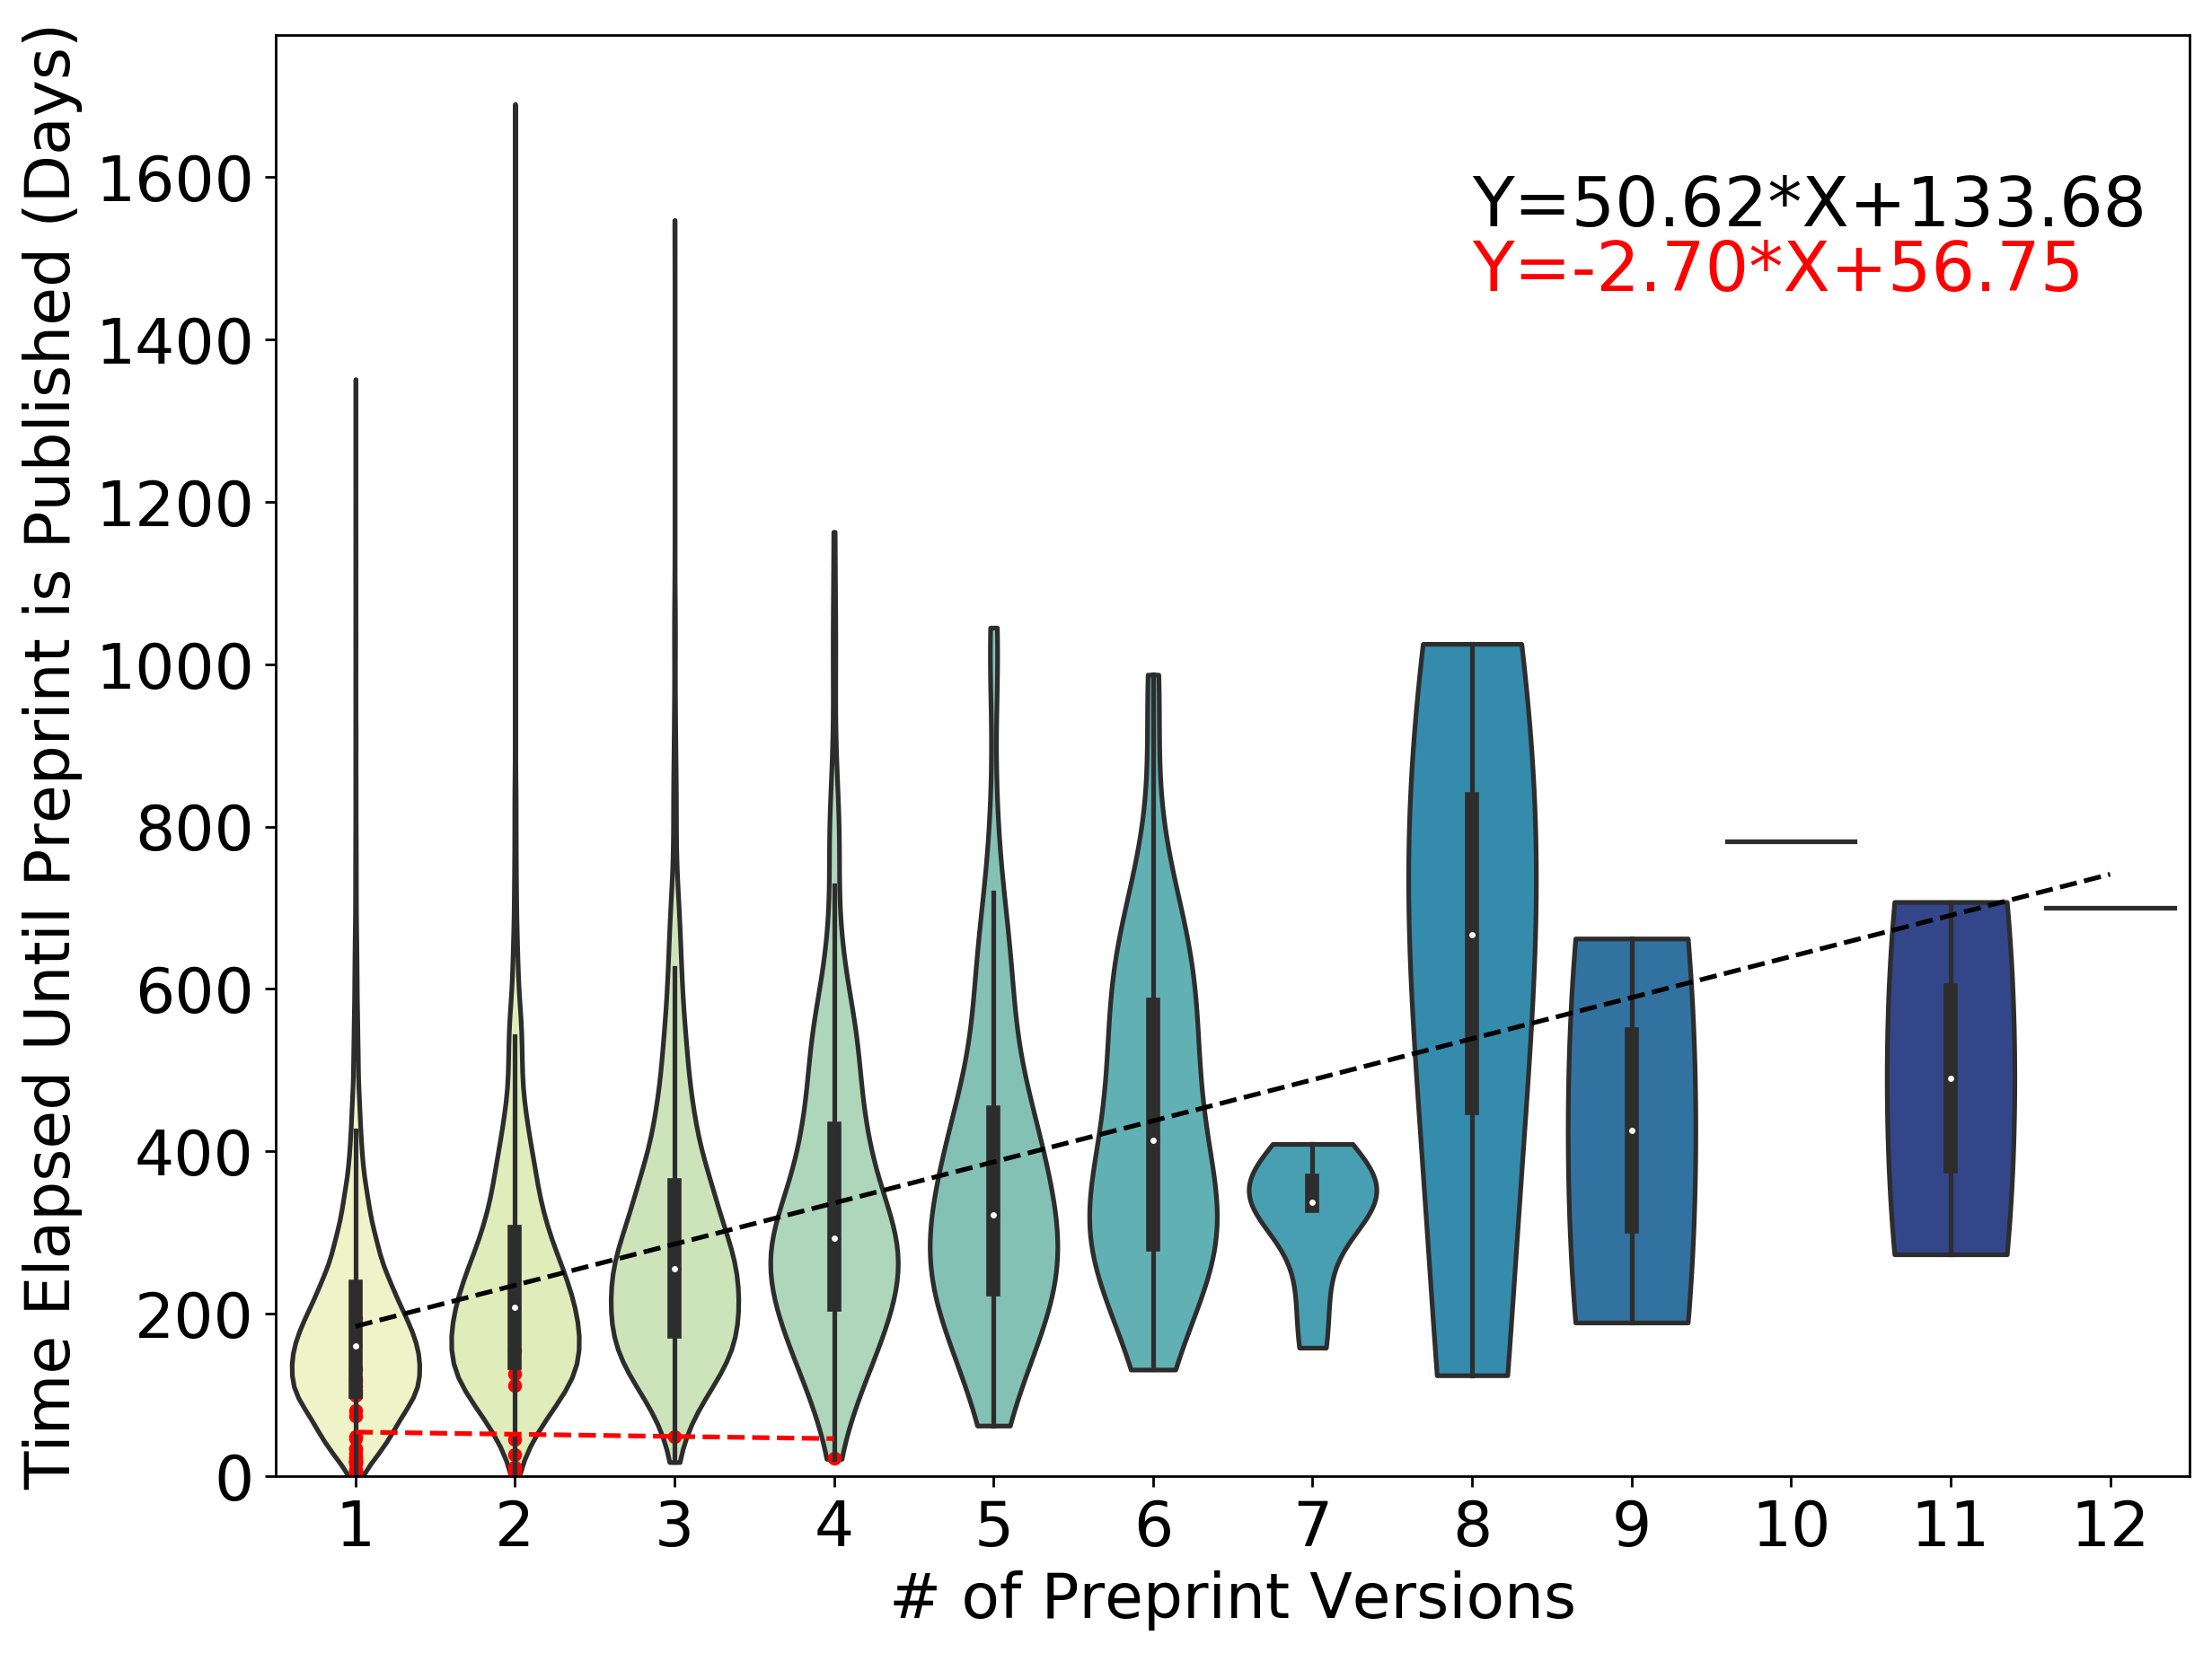

In [15]:
# Graph here?
plt.figure(figsize=(11, 8.5))
plt.rcParams.update({"font.size": 22})
g = sns.violinplot(
    x="version_count",
    y="days_to_published",
    data=biorxiv_published_distances,
    cut=0,
    scale="width",
    palette="YlGnBu",
)

_ = g.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
_ = g.set_xlabel("# of Preprint Versions")
_ = g.plot(x_line - 1, y_line, "--k")
_ = g.plot(polka_x_line - 1, polka_y_line, "--k", color="red")
_ = g.scatter(
    polka_published_preprint_df["version_count"] - 1,
    polka_published_preprint_df["days_to_published"],
    c="red",
    s=12,
)
_ = g.annotate(f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (7, 1540))
_ = g.annotate(
    f"Y={results_3.slope:.2f}*X+{results_3.intercept:.2f}", (7, 1460), color="red"
)
_ = g.set_xlim(-0.5, 11.5)
_ = g.set_ylim(0, g.get_ylim()[1])

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.xaxis.label.set_size(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.yaxis.label.set_size(20)

plt.savefig("output/figures/version_count_vs_publication_time_violin.svg", dpi=500)
plt.savefig("output/figures/version_count_vs_publication_time_violin.png", dpi=500)

## Background Filtered

In [16]:
# Grab the max amount of days possible
polka_published_preprint_df.time_to_published.max()

Timedelta('195 days 00:00:00')

In [17]:
# Get smoothed linear regression line
filtered_biorxiv_published_distances = biorxiv_published_distances[
    biorxiv_published_distances["time_to_published"] < timedelta(days=195)
]
x = filtered_biorxiv_published_distances.version_count.values.tolist()

y = filtered_biorxiv_published_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=10.799651299792142, intercept=104.73729279396566, rvalue=0.14022010303294263, pvalue=3.6333055666201894e-44, stderr=0.7708765516843813, intercept_stderr=1.104760890928072)


In [18]:
x_line = np.array(
    [
        filtered_biorxiv_published_distances["version_count"].min(),
        filtered_biorxiv_published_distances["version_count"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

In [19]:
# Get smoothed linear regression line
polka_x = polka_published_preprint_df.version_count.values.tolist()

polka_y = polka_published_preprint_df.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

results_3 = linregress(polka_x, polka_y)
print(results_3)

LinregressResult(slope=-2.7000000000000006, intercept=56.753846153846155, rvalue=-0.03533588115825079, pvalue=0.8308906713676564, stderr=12.553813478311392, intercept_stderr=18.642003871150774)


In [20]:
polka_x_line = np.array(
    [
        polka_published_preprint_df["version_count"].min(),
        polka_published_preprint_df["version_count"].max(),
    ]
)
polka_y_line = polka_x_line * results_3.slope + results_3.intercept

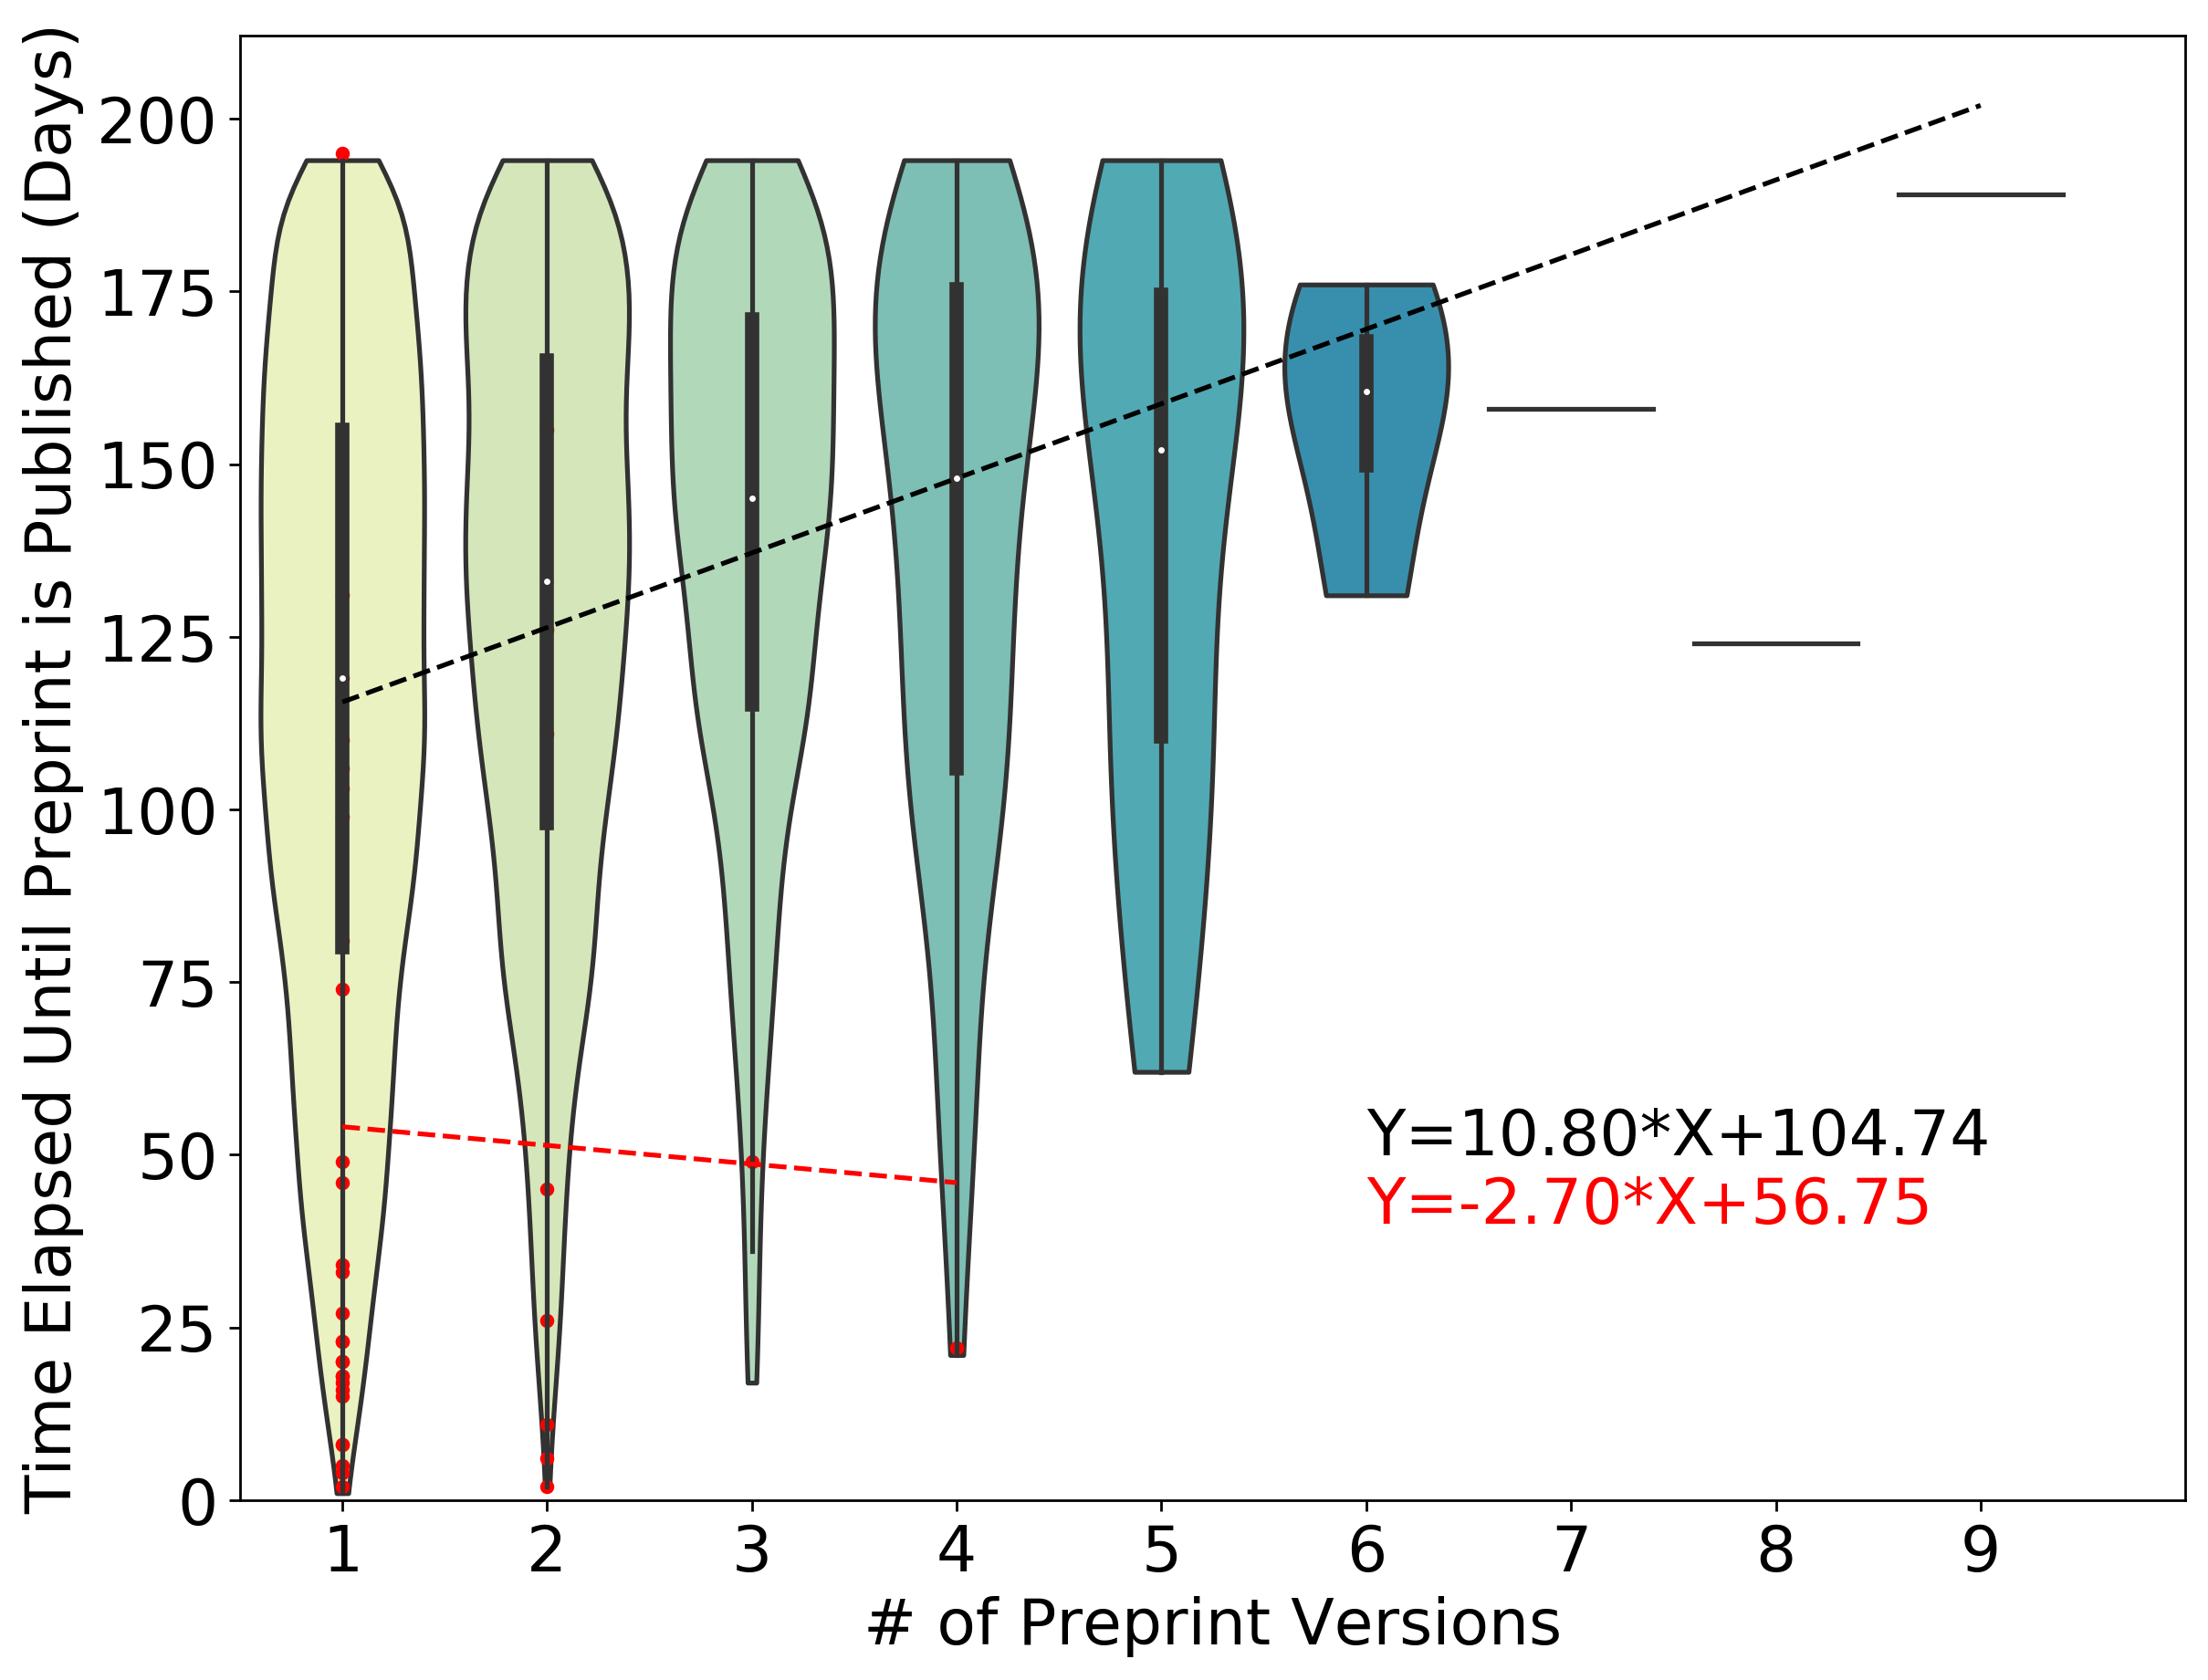

In [21]:
# Graph here?
plt.figure(figsize=(11, 8.5))
plt.rcParams.update({"font.size": 20})
g = sns.violinplot(
    x="version_count",
    y="days_to_published",
    data=filtered_biorxiv_published_distances,
    cut=0,
    scale="width",
    palette="YlGnBu",
)

_ = g.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
_ = g.set_xlabel("# of Preprint Versions")
_ = g.plot(x_line - 1, y_line, "--k")
_ = g.plot(polka_x_line - 1, polka_y_line, "--k", color="red")
_ = g.scatter(
    polka_published_preprint_df["version_count"] - 1,
    polka_published_preprint_df["days_to_published"],
    c="red",
    s=12,
)
_ = g.annotate(f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}", (5, 50))
_ = g.annotate(
    f"Y={results_3.slope:.2f}*X+{results_3.intercept:.2f}", (5, 40), color="red"
)
_ = g.set_xlim(-0.5, 9)
_ = g.set_ylim(0, g.get_ylim()[1])

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.xaxis.label.set_size(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.yaxis.label.set_size(20)

plt.savefig(
    "output/figures/version_count_vs_publication_time_violin_filtered.svg", dpi=500
)
plt.savefig(
    "output/figures/version_count_vs_publication_time_violin_filtered.png", dpi=500
)

# Perform Regression Analysis - Document Distances

In [22]:
polka_published_df = polka_published_df.set_index("document")
polka_published_df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
document,,,,,,,,,,,,,,,,,,,,,
PMC7095418,0.024889,-0.070975,-0.377182,-0.102496,-0.434726,-0.368654,0.028184,0.353945,0.440888,-0.218257,...,0.126341,-0.084509,-0.014971,-0.333411,-0.527903,-0.146963,0.204912,0.419672,-0.734921,0.661554
PMC7054013,0.023555,0.215864,-0.443536,0.047643,-0.164215,-0.307564,-0.111106,0.013011,0.214015,-0.560381,...,0.397822,0.087836,0.176272,-0.185256,-0.406073,-0.111970,0.282327,0.564426,-0.316237,0.304340
PMC7182430,-0.055630,-0.159898,-0.455295,0.131003,-0.007355,-0.376375,-0.220121,0.168082,0.565368,-0.253361,...,0.225263,-0.107139,0.399253,-0.197415,-0.391321,-0.262596,0.429216,0.556789,-0.663488,0.191001
PMC7176908,0.117712,-0.008851,-0.116698,0.319624,-0.250900,-0.397075,0.055953,0.226020,0.259799,-0.583976,...,0.404390,-0.115281,-0.020958,-0.006601,-0.552109,-0.389951,-0.118042,0.743982,-0.158280,0.318420
PMC6907167,0.226095,0.161650,-0.382450,0.504041,-0.202860,-0.007196,0.056299,0.074116,0.199937,-0.492770,...,0.228398,0.293127,0.444479,0.206213,-0.649697,0.104617,0.139984,0.281341,-0.474767,0.466702


In [23]:
polka_preprints_df = polka_preprints_df.set_index("biorxiv_base").drop(
    ["document", "version_count"], axis=1
)
polka_preprints_df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
biorxiv_base,,,,,,,,,,,,,,,,,,,,,
838870,-0.236496,-0.158390,-0.137343,-0.001011,-0.284048,-0.271869,0.041991,0.120466,0.264844,-0.323787,...,0.125062,-0.135080,0.170882,-0.308521,-0.600287,-0.345592,0.039640,0.730110,-0.348575,0.372932
2020.02.13.945485,-0.209540,0.062120,-0.013421,-0.000279,-0.314423,-0.326985,0.110545,0.243373,0.338386,-0.218816,...,-0.119528,0.035750,-0.064431,-0.094898,-0.711048,-0.044813,0.324615,0.655335,-0.402705,0.460434
2020.01.13.905190,0.229247,0.103720,-0.675217,-0.279651,0.141527,-0.414926,-0.125090,0.169768,0.501925,-0.420740,...,0.282492,0.042949,0.182784,-0.178214,-0.292325,0.067889,0.266495,0.434768,-0.672433,0.628961
865089,0.259484,0.187865,-0.476495,0.104272,-0.239906,-0.327997,0.087983,0.278655,0.548521,-0.367887,...,0.273547,0.442512,0.137913,-0.376542,-0.662379,-0.009104,0.152630,0.026150,-0.478900,0.473070
832675,0.331504,0.397300,-0.662221,-0.082239,0.142704,-0.483719,-0.225434,0.289693,0.750071,-0.407192,...,0.357520,0.031200,0.369862,-0.425790,-0.461598,-0.768766,0.229174,0.504789,-0.708815,0.094324


In [24]:
dist = np.diag(
    cdist(
        polka_preprints_df.loc[polka_published_preprint_df["biorxiv_base"]],
        polka_published_df.loc[polka_published_preprint_df["PMCID"]],
    )
)
print(dist)

[0.47375936 2.04539275 0.70668387 1.4625662  0.90859246 0.62022391
 1.80517667 0.36020873 0.50003877 0.92829635 0.99207876 1.91494677
 0.53140412 0.82485557 1.61339151 7.14830682 1.66733865 0.75922853
 0.89680648 0.25934241 1.85628842 0.85458801 0.89741978 0.4389725
 0.6269485  1.30826854 1.51865366 0.54117937 1.39345712 0.71481943
 0.36820635 2.40695611 0.43842842 1.83987354 0.50578827 0.82714682
 2.06052392 1.64974604 0.29296408]


In [25]:
polka_published_preprint_df = polka_published_preprint_df.assign(doc_distances=dist)
polka_published_preprint_df.head()

,biorxiv_doi,published_doi,PMID,PMCID,biorxiv_base,version_count,preprint_category,preprint_date,published_date,time_to_published,days_to_published,doc_distances
1,10.1101/2019.12.19.882274,10.3389/fpls.2020.00355,32373138.0,PMC7176908,2019.12.19.882274,1,plant biology,2019-12-19,2020-04-16,119 days,119,0.473759
4,10.1101/2020.01.22.914952,10.1038/s41586-020-2012-7,32015507.0,PMC7095418,2020.01.22.914952,2,microbiology,2020-01-23,2020-02-03,11 days,11,2.045393
5,10.1101/2020.01.22.915660,10.1038/s41564-020-0688-y,32094589.0,PMC7095430,2020.01.22.915660,1,microbiology,2020-01-22,2020-02-24,33 days,33,0.706684
6,10.1101/2020.01.23.916395,10.1016/j.ijid.2020.01.050,32007643.0,PMC7110798,2020.01.23.916395,2,ecology,2020-01-24,2020-01-30,6 days,6,1.462566
7,10.1101/2020.01.24.915157,10.1002/jmv.25688,31994738.0,PMC7166400,2020.01.24.915157,1,bioinformatics,2020-01-24,2020-01-29,5 days,5,0.908592


## Original

In [26]:
# Get smoothed linear regression line
x = biorxiv_published_distances.doc_distances.values.tolist()

y = biorxiv_published_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

xseq_2 = np.linspace(np.min(x), np.max(x), 80)

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=43.27393641523755, intercept=168.94390477104105, rvalue=0.1994119912464653, pvalue=2.080656543927908e-156, stderr=1.6076610172681676, intercept_stderr=1.7910675887946146)


In [27]:
x_line = np.array(
    [
        biorxiv_published_distances["doc_distances"].min(),
        biorxiv_published_distances["doc_distances"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

In [28]:
polka_x = (polka_published_preprint_df["doc_distances"].values.tolist(),)
polka_y = polka_published_preprint_df.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

results_3 = linregress(polka_x, polka_y)
print(results_3)

LinregressResult(slope=-1.5582234462286726, intercept=55.030061754432246, rvalue=-0.03517618439687711, pvalue=nan, stderr=nan, intercept_stderr=nan)


/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
/home/danich1/anaconda3/envs/annorxiver/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in sqrt


In [29]:
polka_x_line = np.array(
    [
        polka_published_preprint_df["doc_distances"].min(),
        polka_published_preprint_df["doc_distances"].max(),
    ]
)
polka_y_line = polka_x_line * results_3.slope + results_3.intercept

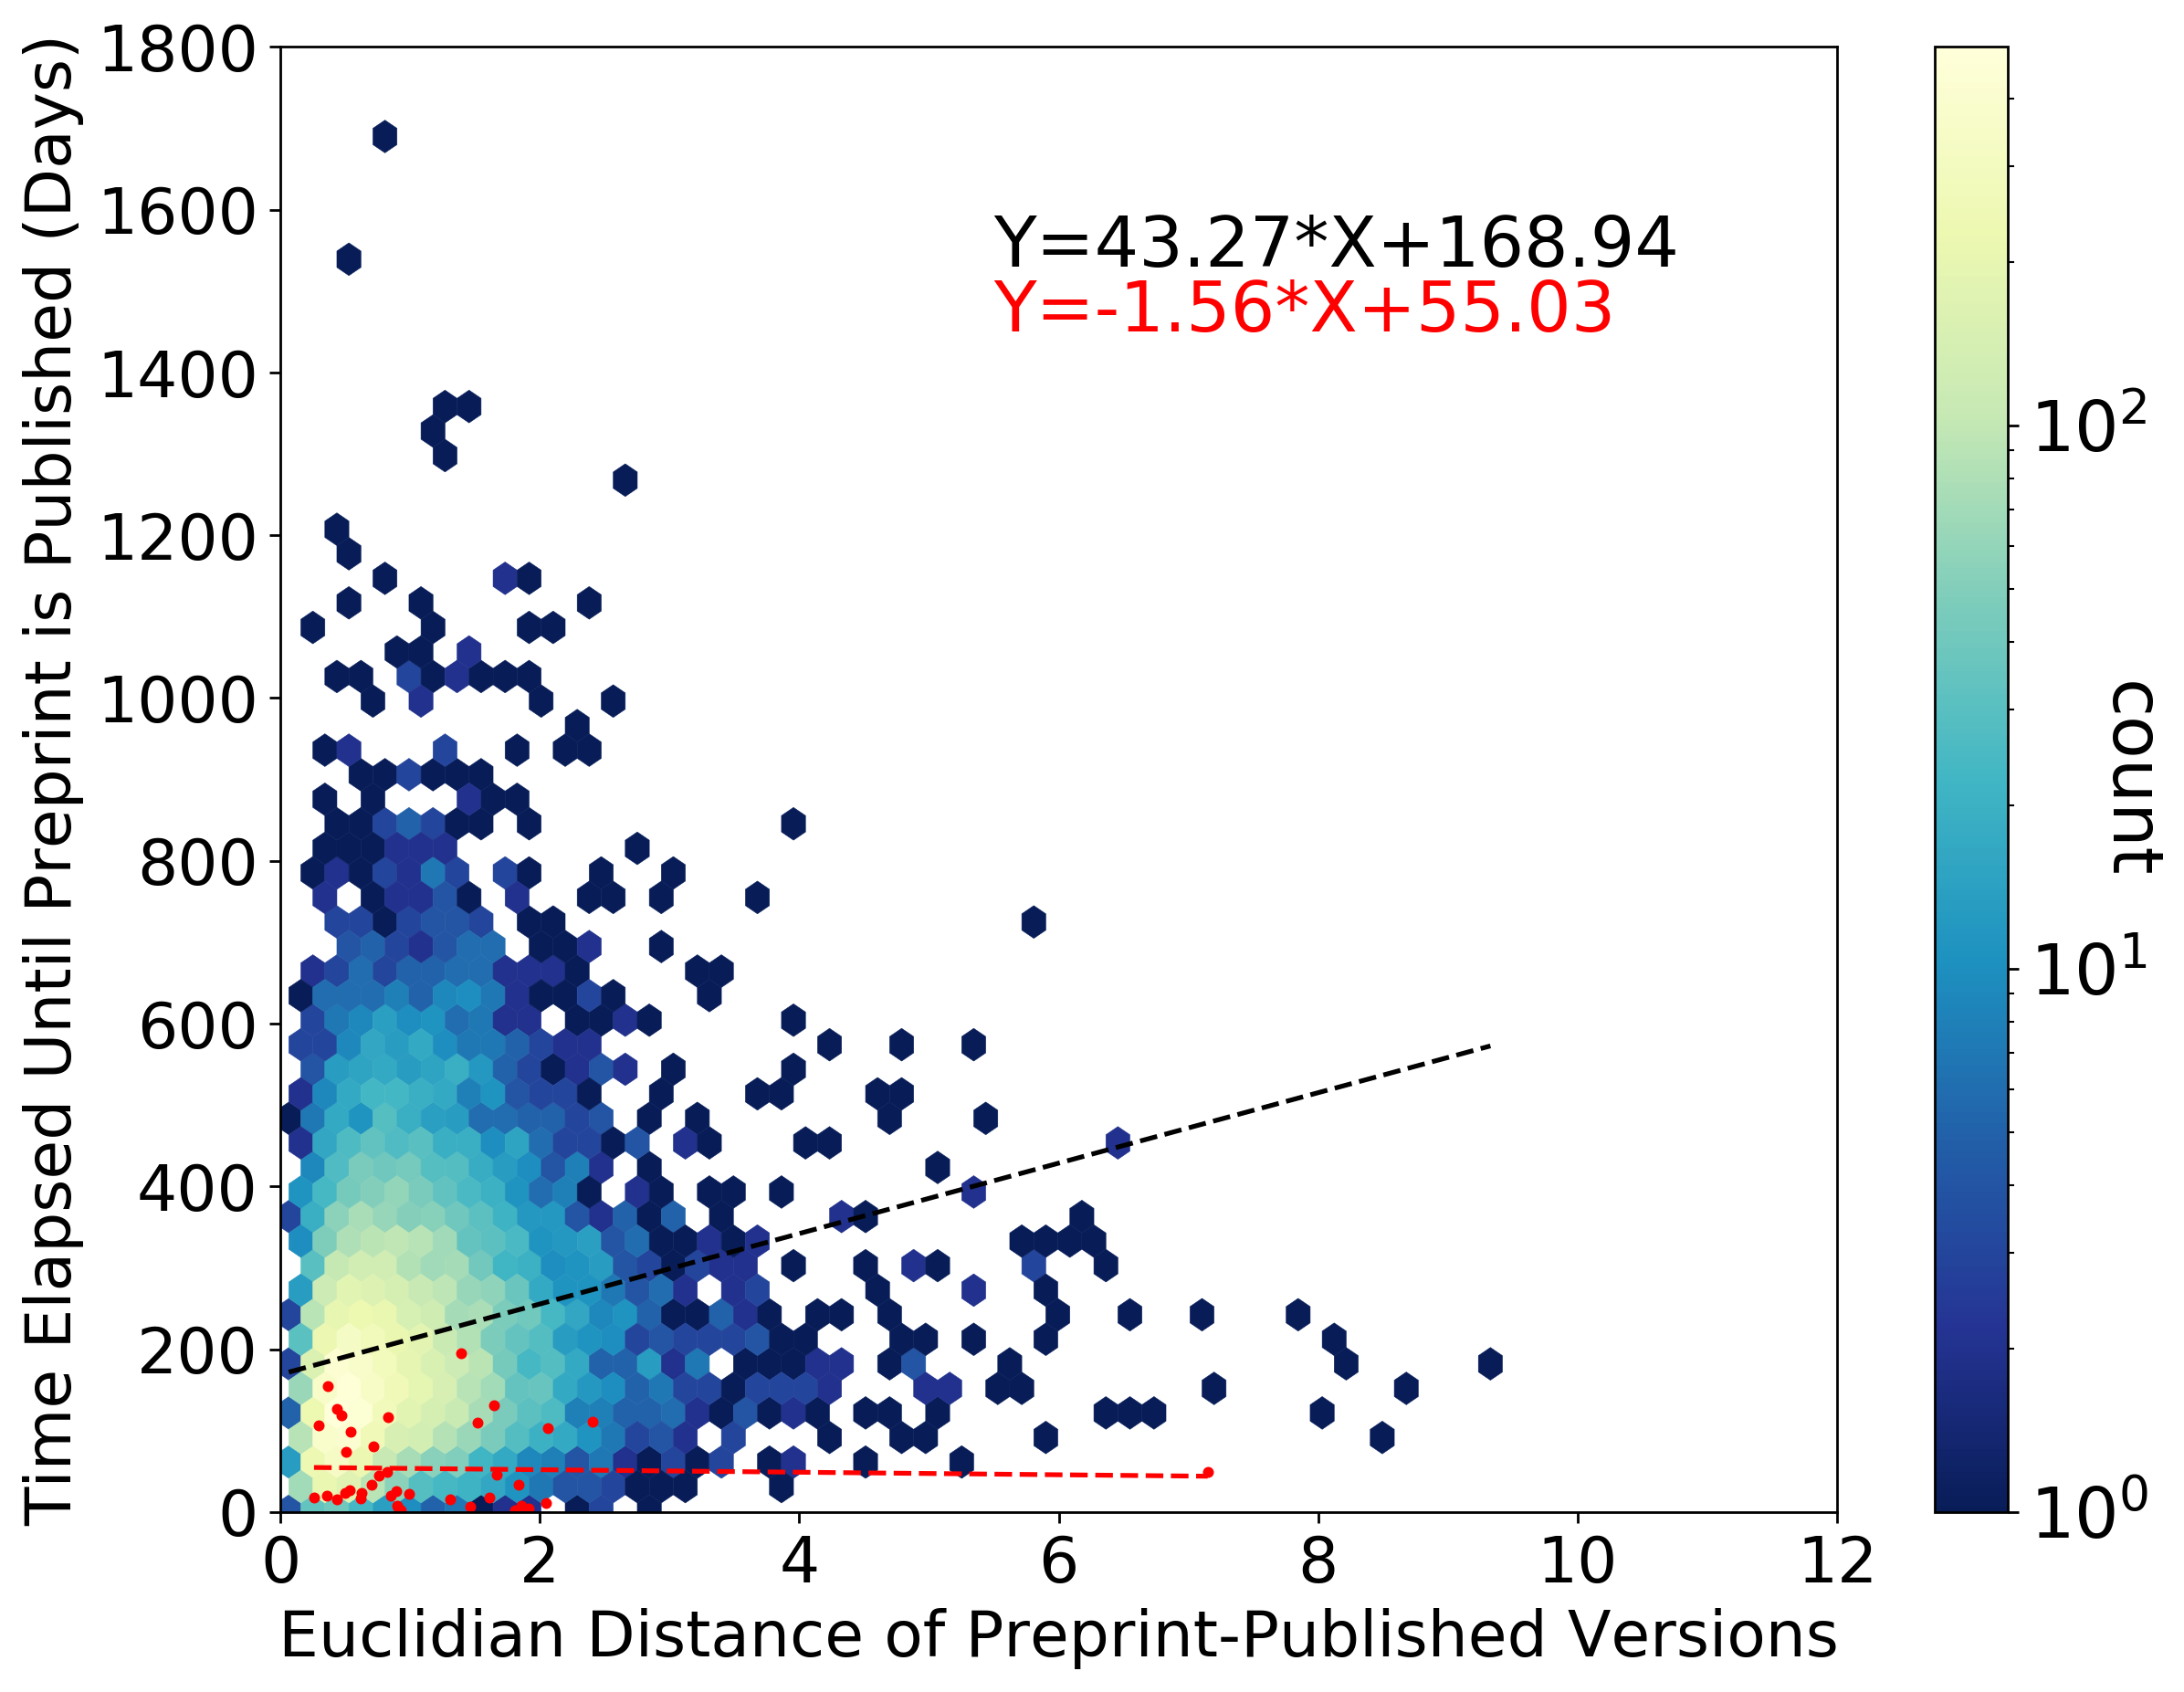

In [30]:
# graph here?
plt.figure(figsize=(11, 8.5))
plt.rcParams.update({"font.size": 22})
ax = plt.hexbin(
    biorxiv_published_distances["doc_distances"],
    biorxiv_published_distances["days_to_published"],
    gridsize=50,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(),
    mincnt=1,
    linewidths=(0.15,)
    #     edgecolors=None
)
plt.xlim([0, 12])
plt.ylim([0, 1800])
ax = plt.gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.xaxis.label.set_size(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.yaxis.label.set_size(20)

ax.plot(x_line, y_line, "--k")
ax.plot(polka_x_line, polka_y_line, "--k", color="red")
ax.annotate(
    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
    (5.5, 1530),
)
_ = ax.annotate(
    f"Y={results_3.slope:.2f}*X+{results_3.intercept:.2f}", (5.5, 1450), color="red"
)
_ = ax.set_xlabel("Euclidian Distance of Preprint-Published Versions")
_ = ax.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("count", rotation=270)
_ = ax.scatter(
    polka_published_preprint_df["doc_distances"],
    polka_published_preprint_df["days_to_published"],
    c="red",
    s=6,
)
plt.savefig("output/figures/article_distance_vs_publication_time_hex.svg", dpi=250)
plt.savefig("output/figures/article_distance_vs_publication_time_hex.png", dpi=250)

## Background Filtered

In [31]:
# Grab the max amount of days possible
polka_published_preprint_df.time_to_published.max()

Timedelta('195 days 00:00:00')

In [32]:
# Get smoothed linear regression line
filtered_biorxiv_published_distances = biorxiv_published_distances[
    biorxiv_published_distances["time_to_published"] < timedelta(days=195)
]
x = filtered_biorxiv_published_distances.doc_distances.values.tolist()

y = filtered_biorxiv_published_distances.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

results_2 = linregress(x, y)
print(results_2)

LinregressResult(slope=9.823755319450793, intercept=110.76756560232195, rvalue=0.1258428970300379, pvalue=7.62602608944192e-36, stderr=0.7828523599120246, intercept_stderr=0.7914781165327474)


In [33]:
x_line = np.array(
    [
        filtered_biorxiv_published_distances["doc_distances"].min(),
        filtered_biorxiv_published_distances["doc_distances"].max(),
    ]
)
y_line = x_line * results_2.slope + results_2.intercept

In [34]:
polka_x = (polka_published_preprint_df["doc_distances"].values.tolist(),)
polka_y = polka_published_preprint_df.time_to_published.apply(
    lambda x: x / timedelta(days=1)
).tolist()

results_3 = linregress(polka_x, polka_y)
print(results_3)

LinregressResult(slope=-1.5582234462286726, intercept=55.030061754432246, rvalue=-0.03517618439687711, pvalue=nan, stderr=nan, intercept_stderr=nan)


In [35]:
polka_x_line = np.array(
    [
        polka_published_preprint_df["doc_distances"].min(),
        polka_published_preprint_df["doc_distances"].max(),
    ]
)
polka_y_line = polka_x_line * results_3.slope + results_3.intercept

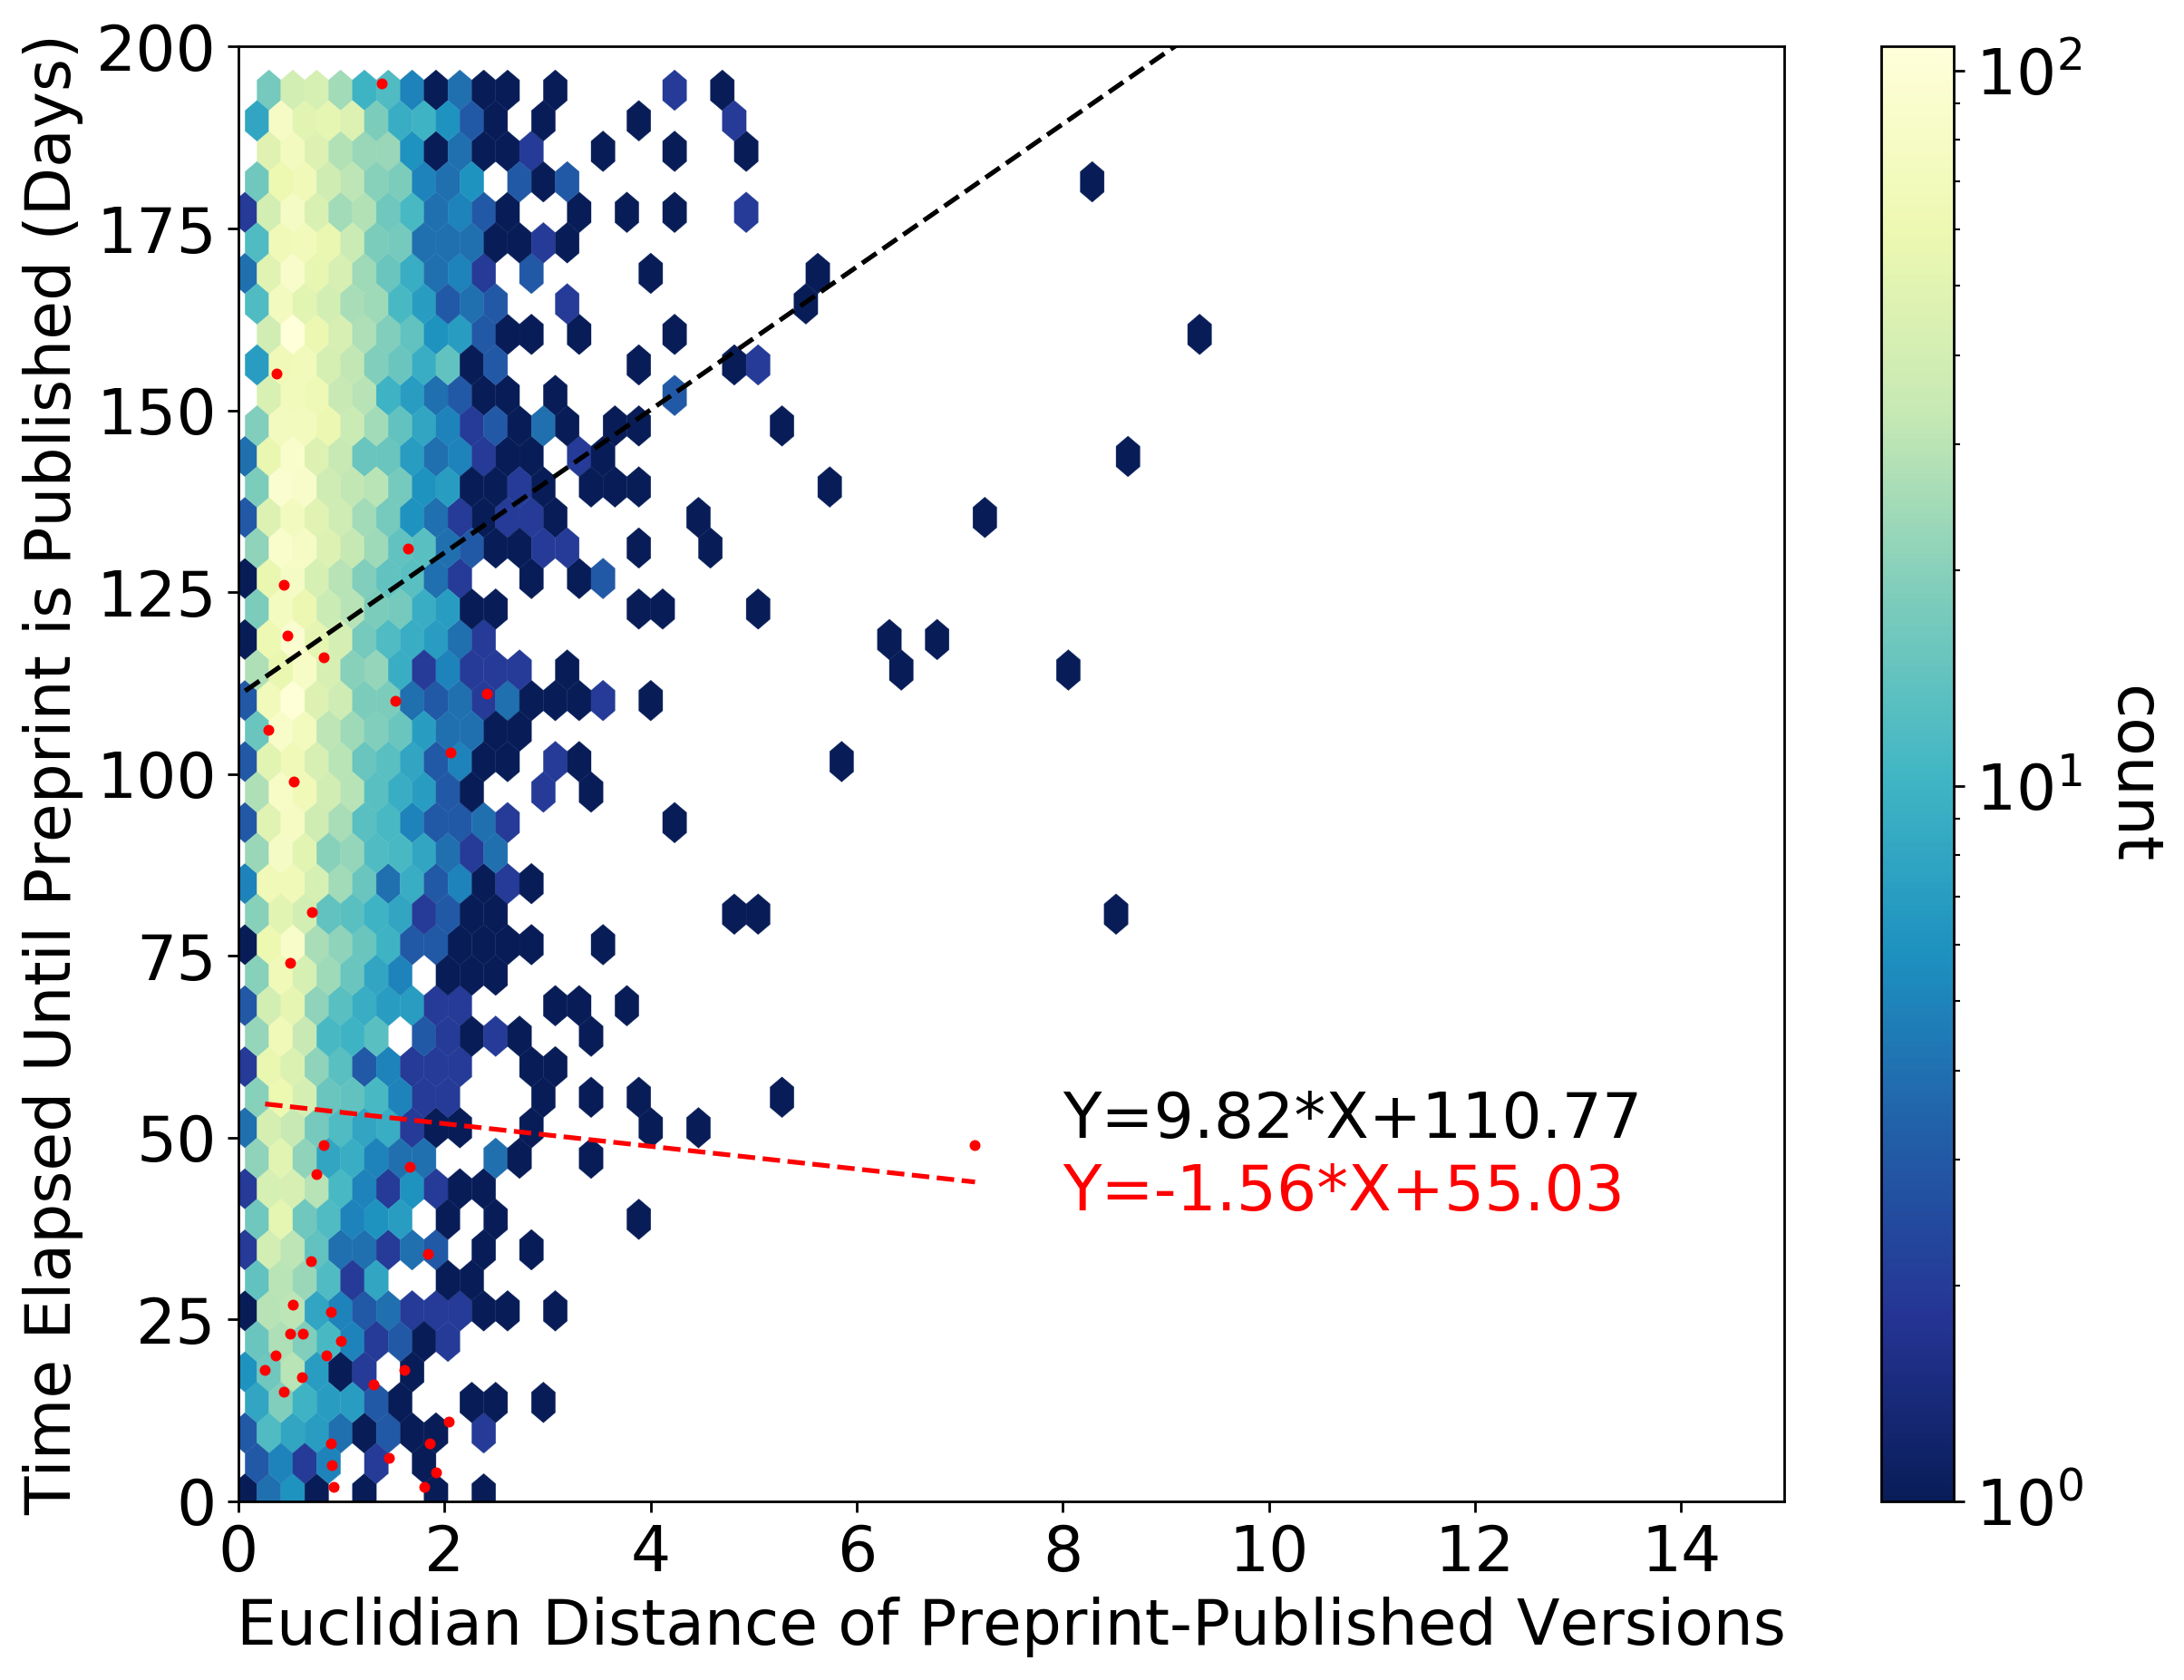

In [36]:
# graph here?
plt.figure(figsize=(11, 8.5))
plt.rcParams.update({"font.size": 20})
ax = plt.hexbin(
    filtered_biorxiv_published_distances["doc_distances"],
    filtered_biorxiv_published_distances["days_to_published"],
    gridsize=40,
    cmap="YlGnBu_r",
    norm=mpl.colors.LogNorm(),
    mincnt=1,
    linewidths=(0.10,)
    #     edgecolors=None
)
plt.xlim([0, 15])
plt.ylim([0, 200])
ax = plt.gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.xaxis.label.set_size(20)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.yaxis.label.set_size(20)

ax.plot(x_line, y_line, "--k")
ax.plot(polka_x_line, polka_y_line, "--k", color="red")
ax.annotate(
    f"Y={results_2.slope:.2f}*X+{results_2.intercept:.2f}",
    (8, 50),
)
_ = ax.annotate(
    f"Y={results_3.slope:.2f}*X+{results_3.intercept:.2f}", (8, 40), color="red"
)
_ = ax.set_xlabel("Euclidian Distance of Preprint-Published Versions")
_ = ax.set_ylabel("Time Elapsed Until Preprint is Published (Days)")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("count", rotation=270, labelpad=25)
_ = ax.scatter(
    polka_published_preprint_df["doc_distances"],
    polka_published_preprint_df["days_to_published"],
    c="red",
    s=6,
)
plt.savefig(
    "output/figures/article_distance_vs_publication_time_hex_filtered.svg", dpi=250
)
plt.savefig(
    "output/figures/article_distance_vs_publication_time_hex_filtered.png", dpi=250
)

# Figure panel generation

In [2]:
fig1 = sg.fromfile(
    "output/figures/version_count_vs_publication_time_violin_filtered.svg"
)
fig2 = sg.fromfile(
    "output/figures/article_distance_vs_publication_time_hex_filtered.svg"
)

fig1_width_size = np.round(float(fig1.root.attrib["width"][:-2]) * 1.33, 0)
fig1_height_size = np.round(float(fig1.root.attrib["height"][:-2]) * 1.33, 0)

fig2_width_size = np.round(float(fig2.root.attrib["width"][:-2]) * 1.33, 0)
fig2_height_size = np.round(float(fig2.root.attrib["height"][:-2]) * 1.33, 0)

fig = sg.SVGFigure(
    Unit((fig1_width_size + fig2_width_size) - 360),
    Unit(min(fig1_height_size, fig2_height_size) - 50),
)

fig.append(
    [etree.Element("rect", {"width": "100%", "height": "100%", "fill": "white"})]
)

plot1 = fig1.getroot()
plot1.moveto(10, 30)

plot2 = fig2.getroot()
plot2.moveto(fig1_width_size - 160, 12)

text_A = sg.TextElement(10, 30, "A", size=22, weight="bold")
text_B = sg.TextElement(fig1_width_size - 160, 30, "B", size=22, weight="bold")

fig.append([plot1, plot2, text_A, text_B])

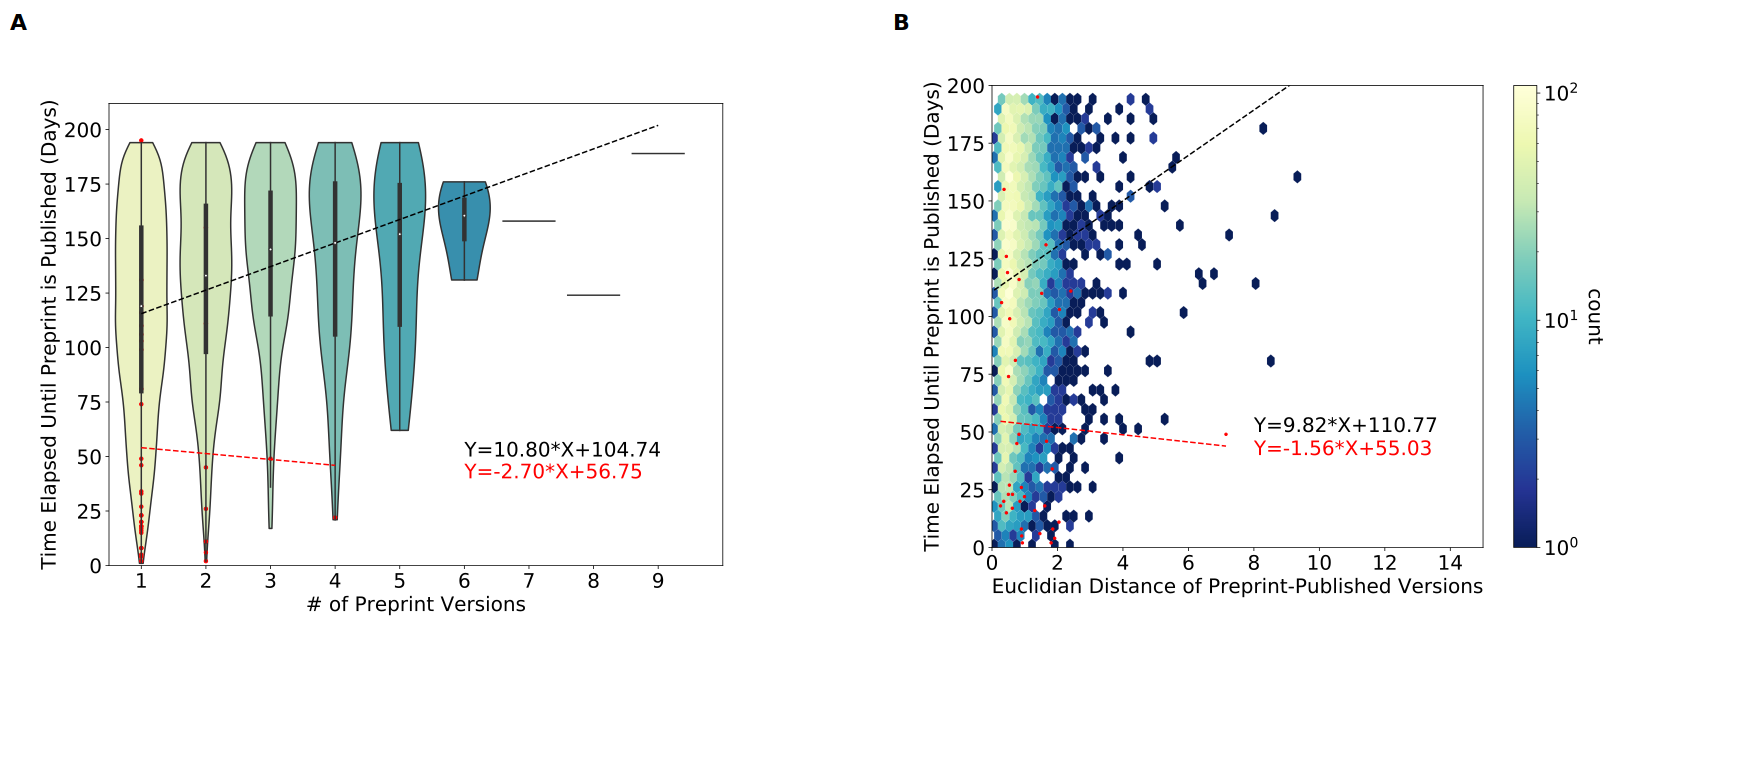

In [4]:
# save generated SVG files
fig.save("output/figures/polka_filtered_background_panels.svg")
svg2png(
    bytestring=fig.to_str(),
    write_to="output/figures/polka_filtered_background_panels.png",
    dpi=600,
)
display(SVG(fig.to_str()))